# Ant sorting

### General rules
No two objects can exist on the same cell

No two ants can exist on the same cell (not yet the case)

In [68]:
import numpy as np
import random

In [69]:
class Ant:
    """Agent that moves object on the grid"""
    
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.laden = False

    def pickup(self, object):
        self.object = object
        self.laden = True
        
    def drop(self, object):
        self.object = 0
        self.laden = False
        
    def move(self):
        neighbours = von_neumann_neighbourhood(self.x, self.y)
        self.x, self.y = neighbours[random.randint(0, len(neighbours) - 1)]
        

In [70]:
def von_neumann_neighbourhood(x, y):
    """return coordinates of all cells in the Von Neumann neighbourhood of the input cell"""
    
    neighbours = []
    if x - 1 >= 0:
        neighbours.append((x - 1, y))
    if x + 1 < grid_size:
        neighbours.append((x + 1, y))
    if y - 1 >= 0:
        neighbours.append((x, y - 1))
    if y + 1 < grid_size:
        neighbours.append((x, y + 1))
        
    return neighbours

In [420]:
def dissimilarity(object_o, object_n):
    """calculate dissimilarity between objects"""
    if object_o == object_n:
        dis = 0
    else:
        dis = 1
    return dis

In [410]:
def local_density(x, y, object):
    """calculate local density"""
    
    neighbourhood = von_neumann_neighbourhood(x, y)
    s2 = len(neighbourhood) + 1
    similarity = 0
    
    for x_n, y_n in neighbourhood:
        similarity += 1 - dissimilarity(object, grid[x_n, y_n])/alpha
        
    return max(0, similarity/s2)

In [411]:
def pickup_probability(local_density):
    """calculate pickup probability"""
    
    return (k1/(k1 + local_density))**2

In [412]:
def drop_probability(local_density):
    """calculate drop probability"""
    
    if local_density < k2:
        probability = 2*local_density
    else:
        probability = 1
        
    return probability

## Parameters

In [449]:
grid_size = 50
ant_density = 0.05
object_density = 0.25
n_object_types = 5
t_total = 10000
k1 = 0.1
k2 = 0.15
alpha = 1

In [450]:
def initiate_grid(grid_size, ant_density, object_density, n_object_types):
    """intiate the grid with objects and ants"""
    
    grid = np.zeros((grid_size, grid_size))
    n_ants = int(ant_density*grid_size**2)
    n_objects = int(object_density*grid_size**2)
    
    for object in range(n_objects):
        color = random.randint(1, n_object_types)
        x = random.randint(0, grid_size - 1)
        y = random.randint(0, grid_size - 1)
        grid[x, y] = color
        
    ants = []
    for ant in range(n_ants):
        x = random.randint(0, grid_size - 1)
        y = random.randint(0, grid_size - 1)
        ants.append(Ant(x, y))
        
    print(f"There are {n_objects} objects and {n_ants} ants on the grid.")    
    return grid, ants

In [451]:
original_grid, ants = initiate_grid(grid_size, ant_density, object_density, n_object_types)

There are 625 objects and 125 ants on the grid.


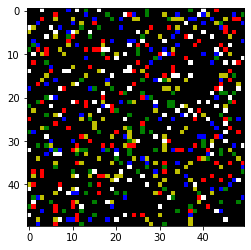

In [452]:
import matplotlib.pyplot as plt
import matplotlib
plt.imshow(original_grid, cmap = matplotlib.colors.ListedColormap(['k', 'r', 'y', 'b', 'w', 'g']))

## Simulation

In [453]:
#grids = [] !!Grid niet elke timestep opslaan, is meerdere GB

grid = np.copy(original_grid)

for t in range(1, t_total):
    
    for ant in ants:
        
        if (ant.laden == False) & (grid[ant.x, ant.y] != 0):
            p_pickup = pickup_probability(local_density(ant.x, ant.y, grid[ant.x, ant.y]))
            
            if random.random() <= p_pickup:
                ant.pickup(grid[ant.x, ant.y])
                grid[ant.x, ant.y] = 0
                
        elif (ant.laden == True) & (grid[ant.x, ant.y] == 0):
            p_drop = drop_probability(local_density(ant.x, ant.y, ant.object))
            
            if random.random() <= p_drop:
                grid[ant.x, ant.y] = ant.object
                ant.drop(grid[ant.x, ant.y])
        
        ant.move()
        #grids.append(np.copy(grid))
        
#for ant in ants:

#    grid[ant.x, ant.y] = ant.object
#    ant.drop(grid[ant.x, ant.y])

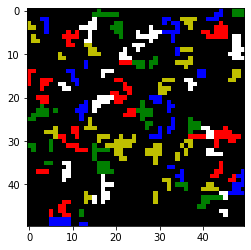

In [454]:
plt.imshow(grid, cmap = matplotlib.colors.ListedColormap(['k', 'r', 'y', 'b', 'w', 'g']))

In [455]:
sum(sum(grid == original_grid))

1573

## With clusters

In [483]:
class Cluster:
    """cluster object"""
    
    def __init__(self):
        self.x = []
        self.y = []
        self.objects = []

    def add_object(self, x, y, object):
        self.x.append(x)
        self.y.append(y)
        self.objects.append(object)
        

In [517]:
def calculate_clusters(grid):
    clusters = []
    cluster_grid = np.zeros((grid_size, grid_size))
    
    #iterate over all grid items
    for x in range(grid_size):
        for y in range(grid_size):
            if grid[x, y] != 0:
                dss = []
                for x_n, y_n in von_neumann_neighbourhood(x, y):

                    #check dissimilarity between neighbours
                    ds = dissimilarity(grid[x, y], grid[x_n, y_n])
                    dss.append(ds)

                    if ds == 0:

                        #check if neighbour is in a cluster, if so, add to the cluster
                        if cluster_grid[x_n, y_n] != 0:
                            clusters[int(cluster_grid[x_n, y_n])].add_object(x, y, grid[x, y])
                            cluster_grid[x, y] = cluster_grid[x_n, y_n]

                        #otherwise, create a new cluster
                        else:
                            clusters.append(Cluster())
                            clusters[len(clusters) - 1].add_object(x, y, grid[x, y])
                            cluster_grid[x, y] = len(clusters) - 1

                        break
                       
                # if the object is alone, no similar neighbors, also make it a cluster    
 #               if sum(dss) == 0:
#                    clusters.append(Cluster())
#                    clusters[len(clusters) - 1].add_object(x, y, grid[x, y])
#                    cluster_grid[x, y] = len(clusters) - 1
                
                    
    return clusters, cluster_grid

In [518]:
clusters, cluster_grid = calculate_clusters(grid)

In [519]:
len(clusters)

213

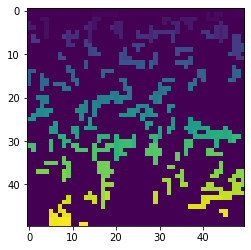

In [520]:
plt.imshow(cluster_grid) # KLOPT NIET, is nie hetzelfde als vorige grid

In [521]:
cluster_types = np.zeros((grid_size, grid_size))

for x in range(grid_size):
    for y in range(grid_size):
        if cluster_grid[x, y] != 0:
            cluster_types[x,y] = clusters[int(cluster_grid[x, y])].objects[0]


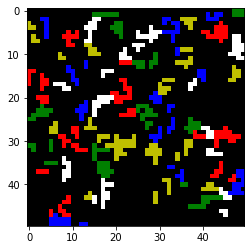

In [522]:
plt.imshow(cluster_types, cmap = matplotlib.colors.ListedColormap(['k', 'r', 'y', 'b', 'w', 'g']))

In [510]:
#grids = []
clusters, cluster_grid = calculate_clusters(grid)

for t in range(1, t_total):
    
    for ant in ants:
        
        if (ant.laden == False) & (grid[ant.x, ant.y] != 0):
            p_pickup = pickup_probability(local_density(ant.x, ant.y, grid[ant.x, ant.y]))
            
            if random.random() <= p_pickup:
                if cluster_grid[ant.x, ant.y] != 0:
                    cluster = clusters[int(cluster_grid[ant.x, ant.y])]
                    ant.pickup(cluster)
                    
 #                   #remove from grid and from cluster_grid
 #                   for i in range(grid_size):
 #                       for j in range(grid_size): 
 #                           if cluster_grid[i, j] == cluster_grid[ant.x, ant.y]:
 #                               cluster_grid[i, j] = 0
                    
                    for i in range(len(cluster.x)):
                        cluster_grid[cluster.x[i], cluster.y[i]] = 0
                        grid[cluster.x[i], cluster.y[i]] = 0
                    
                else: # instead of doing this we can define sigle objects also as clusters, wouldn't lead to problems I think
                    ant.pickup(grid[ant.x, ant.y]) 
                    grid[ant.x, ant.y] = 0
                
        elif (ant.laden == True) & (grid[ant.x, ant.y] == 0):
            p_drop = drop_probability(local_density(ant.x, ant.y, ant.object))
            
            if random.random() <= p_drop:
                grid[ant.x, ant.y] = ant.object
                ant.drop(grid[ant.x, ant.y])
        
        ant.move()
        #grids.append(np.copy(grid))
        
#for ant in ants:

#    grid[ant.x, ant.y] = ant.object
#    ant.drop(grid[ant.x, ant.y])